In [3]:
import os
import sys

print("os.getcwd():", os.getcwd())

# 1) Try to detect if we are in the project root (has 'src' and 'notebooks')
if os.path.isdir("src") and os.path.isdir("notebooks"):
    PROJECT_ROOT = os.getcwd()
    print("Detected PROJECT_ROOT as current directory (has src/ and notebooks/).")
# 2) Or if we are inside notebooks/ folder
elif os.path.basename(os.getcwd()) == "notebooks" and os.path.isdir("../src"):
    PROJECT_ROOT = os.path.abspath("..")
    print("Detected PROJECT_ROOT as parent of notebooks/.")
else:
    # Fallback: assume current dir is project root
    PROJECT_ROOT = os.getcwd()
    print("Fallback PROJECT_ROOT (please check):", PROJECT_ROOT)

# Make sure Python can import src/
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print("Final PROJECT_ROOT:", PROJECT_ROOT)

# Build ABSOLUTE paths
DATA_DIR    = os.path.join(PROJECT_ROOT, "notebooks", "data")
MODELS_ROOT = os.path.join(PROJECT_ROOT, "notebooks", "models")
RESULTS_DIR = os.path.join(PROJECT_ROOT, "notebooks", "results")

print("DATA_DIR   :", DATA_DIR)
print("MODELS_ROOT:", MODELS_ROOT)
print("RESULTS_DIR:", RESULTS_DIR)

# Diagnostics: does notebooks/models exist? What is inside?
print("Exists MODELS_ROOT?:", os.path.isdir(MODELS_ROOT))
if os.path.isdir(MODELS_ROOT):
    print("Content of MODELS_ROOT:", os.listdir(MODELS_ROOT))
else:
    print("WARNING: MODELS_ROOT does not exist at this path.")



os.getcwd(): /Users/malakmaher/Documents/GitHub/Emotion-Recognition/notebooks
Detected PROJECT_ROOT as parent of notebooks/.
Final PROJECT_ROOT: /Users/malakmaher/Documents/GitHub/Emotion-Recognition
DATA_DIR   : /Users/malakmaher/Documents/GitHub/Emotion-Recognition/notebooks/data
MODELS_ROOT: /Users/malakmaher/Documents/GitHub/Emotion-Recognition/notebooks/models
RESULTS_DIR: /Users/malakmaher/Documents/GitHub/Emotion-Recognition/notebooks/results
Exists MODELS_ROOT?: True
Content of MODELS_ROOT: ['run_2025-12-07_02-26-01', 'run_2025-12-07_03-06-47', 'run_2025-12-07_01-50-26', 'run_2025-12-07_02-22-47']


In [4]:
import os
import json
import glob
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from src.data_loader import load_train_val_test

# Emotion labels – must match training & predict.py
EMOTION_LABELS = [
    "neutral",   # 0
    "calm",      # 1
    "happy",     # 2
    "sad",       # 3
    "angry",     # 4
    "fearful",   # 5
    "disgust",   # 6
    "surprised"  # 7
]

# Use project-root-aware paths to avoid duplicate notebooks/ paths
if 'PROJECT_ROOT' in globals():
    PROJECT_ROOT = PROJECT_ROOT
elif os.path.isdir('src') and os.path.isdir('notebooks'):
    PROJECT_ROOT = os.getcwd()
elif os.path.basename(os.getcwd()) == 'notebooks' and os.path.isdir('../src'):
    PROJECT_ROOT = os.path.abspath('..')
else:
    PROJECT_ROOT = os.getcwd()

DATA_DIR = os.path.join(PROJECT_ROOT, 'notebooks', 'data')
MODELS_ROOT = os.path.join(PROJECT_ROOT, 'notebooks', 'models')
RESULTS_DIR = os.path.join(PROJECT_ROOT, 'results')
os.makedirs(RESULTS_DIR, exist_ok=True)


In [5]:
import glob

def get_latest_run(models_root=MODELS_ROOT):
    run_dirs = sorted(
        glob.glob(os.path.join(models_root, "run_*")),
        reverse=True
    )
    print("Found run dirs:", run_dirs)
    if not run_dirs:
        raise FileNotFoundError(f"No run_* folders found under {models_root}")
    return run_dirs[0]

latest_run = get_latest_run()
print("Using run folder:", latest_run)

best_model_path = os.path.join(latest_run, "best_model.h5")
history_path    = os.path.join(latest_run, "history.json")

print("Best model path :", best_model_path)
print("History path    :", history_path)


Found run dirs: ['/Users/malakmaher/Documents/GitHub/Emotion-Recognition/notebooks/models/run_2025-12-07_03-06-47', '/Users/malakmaher/Documents/GitHub/Emotion-Recognition/notebooks/models/run_2025-12-07_02-26-01', '/Users/malakmaher/Documents/GitHub/Emotion-Recognition/notebooks/models/run_2025-12-07_02-22-47', '/Users/malakmaher/Documents/GitHub/Emotion-Recognition/notebooks/models/run_2025-12-07_01-50-26']
Using run folder: /Users/malakmaher/Documents/GitHub/Emotion-Recognition/notebooks/models/run_2025-12-07_03-06-47
Best model path : /Users/malakmaher/Documents/GitHub/Emotion-Recognition/notebooks/models/run_2025-12-07_03-06-47/best_model.h5
History path    : /Users/malakmaher/Documents/GitHub/Emotion-Recognition/notebooks/models/run_2025-12-07_03-06-47/history.json


In [14]:
from src.data_loader import load_train_val_test

DATA_DIR = "/Users/malakmaher/Documents/GitHub/Emotion-Recognition/notebooks/data"

X_train, X_val, X_test, y_train, y_val, y_test,label_names = load_train_val_test(
    data_dir=DATA_DIR,
    test_size=0.15,
    val_size=0.15,
    random_state=42,
    one_hot=True
)

print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_val:", y_val.shape)
print("y_test:", y_test.shape)


Loaded X: (1440, 128, 128, 1)
Loaded y: (1440,)
Train: X=(1008, 128, 128, 1), y=(1008, 8)
Val:   X=(216, 128, 128, 1), y=(216, 8)
Test:  X=(216, 128, 128, 1), y=(216, 8)
X_train: (1008, 128, 128, 1)
X_val: (216, 128, 128, 1)
X_test: (216, 128, 128, 1)
y_train: (1008, 8)
y_val: (216, 8)
y_test: (216, 8)


In [15]:
model = load_model(best_model_path)

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

# Save text output
with open(os.path.join(RESULTS_DIR, "test_metrics.txt"), "w") as f:
    f.write(f"Test loss: {test_loss}\n")
    f.write(f"Test accuracy: {test_acc}\n")


7/7 [==============================] - 1s 81ms/step - loss: 1.5919 - accuracy: 0.4259
Test loss: 1.5919
Test accuracy: 0.4259


7/7 [==============================] - 1s 71ms/step


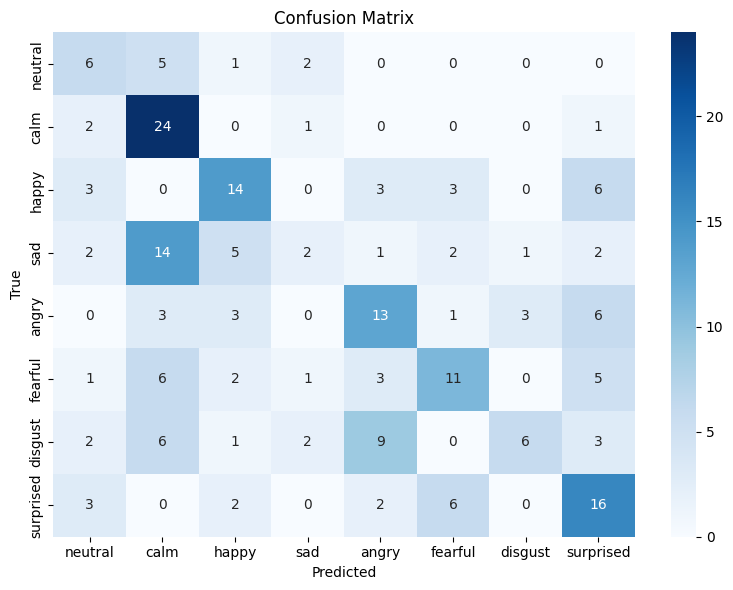

              precision    recall  f1-score   support

     neutral       0.32      0.43      0.36        14
        calm       0.41      0.86      0.56        28
       happy       0.50      0.48      0.49        29
         sad       0.25      0.07      0.11        29
       angry       0.42      0.45      0.43        29
     fearful       0.48      0.38      0.42        29
     disgust       0.60      0.21      0.31        29
   surprised       0.41      0.55      0.47        29

    accuracy                           0.43       216
   macro avg       0.42      0.43      0.39       216
weighted avg       0.43      0.43      0.40       216



In [16]:
y_true = np.argmax(y_test, axis=1)
y_prob = model.predict(X_test)
y_pred = np.argmax(y_prob, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
            xticklabels=EMOTION_LABELS,
            yticklabels=EMOTION_LABELS)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "confusion_matrix.png"), dpi=300)
plt.show()

# Classification report
report = classification_report(y_true, y_pred, target_names=EMOTION_LABELS)
print(report)

with open(os.path.join(RESULTS_DIR, "classification_report.txt"), "w") as f:
    f.write(report)


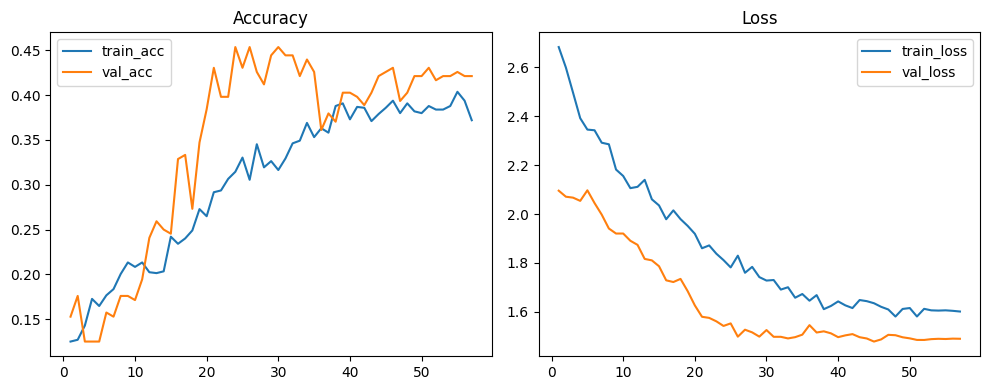

In [17]:
with open(history_path, "r") as f:
    history = json.load(f)

epochs = range(1, len(history["loss"]) + 1)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(epochs, history["accuracy"], label="train_acc")
plt.plot(epochs, history["val_accuracy"], label="val_acc")
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs, history["loss"], label="train_loss")
plt.plot(epochs, history["val_loss"], label="val_loss")
plt.legend()
plt.title("Loss")

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "training_curves.png"), dpi=300)
plt.show()
